# 3 Feature Encoding

In this chapter we load the data, experiment with different model architectures and finally train the autoencoder model. 

### Imports:

In [ ]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Flatten, Reshape, UpSampling2D, Dense, Conv1D, Conv2D, MaxPooling2D, GlobalMaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import visualkeras

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## 3.3 Train Autoencoder

### Load Data

In [ ]:
x_train = pickle.load(open( "./data/x_train.p", "rb" ))
y_train = pickle.load(open( "./data/y_train.p", "rb" ))
x_test  = pickle.load(open( "./data/x_test.p",  "rb" ))
y_test  = pickle.load(open( "./data/y_test.p",  "rb" ))

#### Define Model

In [96]:
##############################
# Encoder
##############################

scale = 2

input_img = Input(shape=(32, 32, 3))
x = Conv2D(scale * 128, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(scale * 64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(scale * 32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(scale * 16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
# with dense from 256 to 10
encoded = Dense(10, activation='sigmoid')(x)

##############################
# Decoder
##############################

# with dense from 10 to 256
x = Dense(64, activation='relu')(encoded)
x = Reshape((2, 2, 16))(x)
x = Conv2D(scale * 16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(scale * 32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(scale * 64, (2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(scale * 128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [97]:
autoencoder = Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0007), loss='mse')

![Autoencoder](./figures/autoencoder.png)

#### Load pretrained models if available

In [ ]:
#model.load_weights(saveDir + "AutoEncoder_Cifar10_Deep_weights_smallLatent_adjusted.03-0.57-0.57.hdf5")

#### Setup callbacks

In [98]:
# callbacks for storing trained weights
saveDir = "./models/checkpoints/"

es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_Deep_weights_smallLatent_adjusted_10.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

log_dir = "./logs/fit_conv_final/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [99]:
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=32,
                verbose=1,
                shuffle=True,
                validation_split = 0.3,
                callbacks=[es_cb, cp_cb, tensorboard_callback]
               )

Epoch 1/100
1094/1094 [==============================] - 33s 20ms/step - loss: 0.0314 - val_loss: 0.0244

Epoch 00001: val_loss improved from inf to 0.02438, saving model to ./models/checkpoints/AutoEncoder_Cifar10_Deep_weights_smallLatent_adjusted_10.01-0.03-0.02.hdf5
Epoch 2/100
1094/1094 [==============================] - 21s 19ms/step - loss: 0.0229 - val_loss: 0.0231

Epoch 00002: val_loss improved from 0.02438 to 0.02312, saving model to ./models/checkpoints/AutoEncoder_Cifar10_Deep_weights_smallLatent_adjusted_10.02-0.02-0.02.hdf5
Epoch 3/100
1094/1094 [==============================] - 21s 19ms/step - loss: 0.0224 - val_loss: 0.0215

Epoch 00003: val_loss improved from 0.02312 to 0.02150, saving model to ./models/checkpoints/AutoEncoder_Cifar10_Deep_weights_smallLatent_adjusted_10.03-0.02-0.02.hdf5
Epoch 4/100
1094/1094 [==============================] - 21s 19ms/step - loss: 0.0222 - val_loss: 0.0224

Epoch 00004: val_loss did not improve from 0.02150
Epoch 5/100
1094/1094 [==

#### Evaluate Model

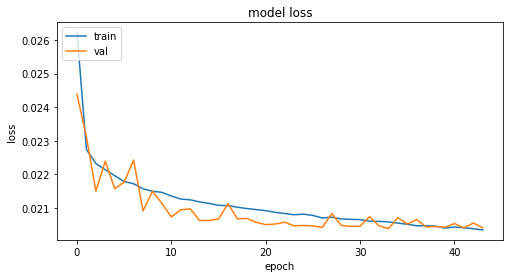

In [100]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Save Model

In [101]:
autoencoder.save('models/autoencoder.hdf5')
autoencoder.save_weights('models/autoencoder_weights.hdf5')
encoder.save('models/encoder.hdf5')